# Evolving Convolutional Neural Network architectures using Genetic Programming - Computing with Sticks
In this notebook, a Convolutional Neural Network (CNN) architecture is optimized on a subset of the CIFAR-10 dataset through Cartesian Genetic Programming (CGP). This CNN architecture is then trained on the full CIFAR-10 dataset, and the results are evaluated. Run all cells to do a single run, which goes through the **initialization phase**, **optimization phase**, and the **evuluation phase**. In the initialization phase, the code required before the optimization phase is run, and some parameters are set. In the optimization phase, the CGP does its work, and this results in a single optimized architecture. This phase also yields a plot which shows the validation performance per generation. In the evaluation phase, this architecture is trained on the full CIFAR-10 dataset and tested on the test set of CIFAR-10. This yields a test accuracy, as well as a plot of the resulting architecture. 

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

import tensorflow as tf
import tensorflow.keras as keras
from keras import layers, models, activations
from keras.models import Model
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

Using TensorFlow backend.


## Initialization
### CGP Parameter Configuration
The '**levels back**'-parameter (level_back) and the '**number of columns**'-paramater (cols) from the report can be set in this code cell. The mutation rate can be specified later on.

In [2]:
# List of blocks
convset = ['ConvBlock32_3',
           'ConvBlock32_5',
           'ConvBlock64_3',
           'ConvBlock64_5',
           'ConvBlock128_3',
           'ConvBlock128_5',
           'pool_max',
           'pool_ave']

# List of how many inputs each block receives, indexes align with the blocks in convset
func_in_num = [1,
               1,
               1,
               1,
               1,
               1,
               1,
               1,
               1,
               1]

# CGP vars
input_num = 1 #number of input layers
out_num = 1 #number of output layers
out_type = ['full'] #types of output layers
out_in_num = [1] #number of inputs the output layer takes

# CGP grid configuration
rows = 1
cols = 30
node_num = rows * cols
level_back = 10 #how many layers back connections can be made

func_type_num = len(convset)
out_type_num = len(out_type)
max_in_num = np.max([np.max(func_in_num), np.max(out_in_num)])

### Functions used in initialization

In [3]:
# initialize parent gene
def init_gene():
    for n in range(node_num + out_num):
        # type gene
        type_num = func_type_num if n < node_num else out_type_num
        gene[n][0] = np.random.randint(type_num)
        # connection gene
        col = np.min((int(n / rows), cols))
        max_connect_id = col * rows + input_num
        min_connect_id = (col - level_back) * rows + input_num if col - level_back >= 0 else 0
        for i in range(max_in_num):
            gene[n][i + 1] = min_connect_id + np.random.randint(max_connect_id - min_connect_id)

In [4]:
# function to check if input connects to output, starts from output
def check_course_to_out(gene, is_active, n):
    if not is_active[n]:
        is_active[n] = True
        t = gene[n][0]
        if n >= node_num:    # output node
            in_num = out_in_num[t]
        else:    # intermediate node
            in_num = func_in_num[t]

        for i in range(in_num):
            if gene[n][i+1] >= input_num:
                check_course_to_out(gene, is_active, gene[n][i+1] - input_num)
        return is_active

### Initialization phase code

In [5]:
# make np.array to use for first gene, parent
gene = np.zeros((node_num + out_num, max_in_num + 1)).astype(int)
#print(gene)

# make np.array with bools to use which layers are active
is_active = np.empty(node_num + out_num).astype(bool)
#print(is_active)

# keep initializing first gene until one is found with an active input and output node
is_active[:] = False
first_layer_is_conv = False
while( not is_active[-1]  ): 
    is_active[:] = False
    init_gene()
    is_active = check_course_to_out(gene, is_active, node_num)
    index_first_layer = np.where(is_active == True)[0][0]
    #print(index_first_layer)
    first_layer_is_conv = gene[index_first_layer][0] < 6
    #print(first_layer_is_conv) 
print(gene, '\n')
print(is_active)

unique, counts = np.unique(is_active, return_counts=True)
dict(zip(unique, counts))

[[ 1  0]
 [ 6  0]
 [ 4  1]
 [ 5  3]
 [ 3  0]
 [ 3  5]
 [ 4  2]
 [ 7  3]
 [ 6  6]
 [ 6  6]
 [ 3  4]
 [ 4 11]
 [ 2 10]
 [ 6 12]
 [ 7  9]
 [ 5  8]
 [ 3 13]
 [ 2 12]
 [ 1 18]
 [ 5 18]
 [ 5 16]
 [ 0 17]
 [ 7 21]
 [ 2 19]
 [ 3 23]
 [ 3 16]
 [ 6 22]
 [ 4 21]
 [ 4 28]
 [ 4 20]
 [ 0 28]] 

[ True False  True False False False False  True False False False False
 False False False  True False False False False  True False False False
 False False False  True False False  True]


{False: 24, True: 7}

## Optimization

### Functions used in optimization
Mutation functions:

In [6]:
# mutation of gene value
def mutate(gene_int, min_int, max_int):
    #print()
    #print('MUTATE')
    #print(gene_int)
    mutated_gene_int = gene_int
    while gene_int == mutated_gene_int:
        mutated_gene_int = min_int + np.random.randint(max_int - min_int)
    #print(mutated_gene_int)
    #print()
    return mutated_gene_int

def mutation(gene_to_mutate, is_active, mutation_rate=0.01):
    active_check = False # value for checking if an active node mutated
    gene = np.copy(gene_to_mutate)
    for n in range(node_num+out_num):
        # type mutation
        t = gene[n, 0] # type int
        type_num = func_type_num if n < node_num else out_type_num # lengths of list of numbers it could mutate into
        if np.random.rand() < mutation_rate and type_num > 1: # mutate if random is higher than mutation rate and there is more than one possible int for the type
            gene[n,0] = mutate(gene[n, 0], 0, type_num)
            if is_active[n]: # if the type of an active layer was mutated, set active_check true
                active_check = True
                #print('TYPE')
                #print(n)
                #print(gene_to_mutate[n])
                #print(gene[n])
        # connection mutation
        # calculate to which the connection part of the gene may connect to
        col = np.min((int(n / rows), cols))
        max_connect_id = col * rows + input_num
        min_connect_id = (col - level_back) * rows + input_num if (col - level_back >= 0) else 0
        in_num = func_in_num[t] if n < node_num else out_in_num[t] # how much inputs the layer takes
        # iterate through connection ints of the gene for mutation
        for i in range(max_in_num):
            if np.random.rand() < mutation_rate and max_connect_id - min_connect_id > 1:
                gene[n, i+1] = mutate(gene[n, i+1], min_connect_id, max_connect_id)
                if is_active[n] and i < in_num: # if the connection of an active layer was mutated, and the layer uses that connection value, set active_check true
                    active_check = True
                    #print('CONNECT')
                    #print(n)
                    #print(gene_to_mutate[n])
                    #print(gene[n])
    
    new_is_active = np.copy(is_active)
    #print(new_is_active)
    new_is_active[:] = False
    #print(new_is_active)
    #print()
    new_is_active = check_course_to_out(gene, new_is_active, node_num)
    return gene, new_is_active, active_check

# mutate until an active layer is mutated
#active_check = False
#while not active_check:
#    print(active_check)
#    mutated_gene, mutated_is_active, active_check = mutation(gene, is_active)
#print(gene)
#print(mutated_gene)
#print(is_active)
#print(mutated_is_active)

In [7]:
def neutral_mutation(gene_to_mutate, is_active, mutation_rate=0.01):
    gene = np.copy(gene_to_mutate)
    for n in range(node_num+out_num):
        # type mutation
        t = gene[n, 0] # type int
        type_num = func_type_num if n < node_num else out_type_num # lengths of list of numbers it could mutate into
        if not is_active[n] and np.random.rand() < mutation_rate and type_num > 1: # mutate if random is higher than mutation rate and there is more than one possible int for the type
            gene[n, 0] = mutate(gene[n, 0], 0, type_num)
            #print('TYPE')
            #print(n)
            #print(gene_to_mutate[n])
            #print(gene[n])
        # connection mutation
        # calculate to which the connection part of the gene may connect to
        col = np.min((int(n / rows), cols))
        max_connect_id = col * rows + input_num
        min_connect_id = (col - level_back) * rows + input_num if (col - level_back >= 0) else 0
        in_num = func_in_num[t] if n < node_num else out_in_num[t] # how much inputs the layer takes
        # iterate through connection ints of the gene for mutation
        for i in range(max_in_num):
            if (not is_active[n] or i >= in_num) and np.random.rand() < mutation_rate and max_connect_id - min_connect_id > 1:
                gene[n, i+1] = mutate(gene[n, i+1], min_connect_id, max_connect_id)
                #print('CONNECT')
                #print(n)
                #print(gene_to_mutate[n])
                #print(gene[n])
    
    new_is_active = np.copy(is_active)
    new_is_active[:] = False
    new_is_active = check_course_to_out(gene, new_is_active, node_num)
    return gene, new_is_active

#neutral_mutated_gene, neutral_mutated_is_active = neutral_mutation(gene, is_active)

Convert genotype to CNN function:

In [8]:
# gene to keras network
def genotype_to_cnn(genotype, is_active):
    network = keras.models.Sequential()
    network.add(keras.layers.Input(shape=(32,32,3)))
    for i,gene in enumerate(genotype):
        if is_active[i]:
            #Layers
            #print(gene)
            #print(convset[gene[0]])
            #print()
            if i==len(genotype)-1: # if last layer of gene
                network.add(keras.layers.GlobalAveragePooling2D()) 
                if out_type[gene[0]] == 'full':     
                    network.add(keras.layers.Dense(units=10, activation='softmax'))
            elif convset[gene[0]] == 'ConvBlock32_3':
                network.add(keras.layers.Conv2D(filters=32,kernel_size=3,padding='same'))
            elif convset[gene[0]] == 'ConvBlock32_5':
                network.add(keras.layers.Conv2D(filters=32,kernel_size=5,padding='same'))
            elif convset[gene[0]] == 'ConvBlock64_3':
                network.add(keras.layers.Conv2D(filters=64,kernel_size=3,padding='same'))
            elif convset[gene[0]] == 'ConvBlock64_5':
                network.add(keras.layers.Conv2D(filters=64,kernel_size=5,padding='same'))
            elif convset[gene[0]] == 'ConvBlock128_3':
                network.add(keras.layers.Conv2D(filters=128,kernel_size=3,padding='same'))
            elif convset[gene[0]] == 'ConvBlock128_5':
                network.add(keras.layers.Conv2D(filters=128,kernel_size=5,padding='same'))
            elif convset[gene[0]] == 'ConvBlock256_3':
                network.add(keras.layers.Conv2D(filters=256,kernel_size=3,padding='same'))
            elif convset[gene[0]] == 'ConvBlock256_5':
                network.add(keras.layers.Conv2D(filters=256,kernel_size=5,padding='same'))
            elif convset[gene[0]] == 'pool_max':
                try:
                    network.add(keras.layers.MaxPooling2D(pool_size=2))
                except:
                    return 'Could not build'
            elif convset[gene[0]] == 'pool_ave':
                try:
                    network.add(keras.layers.AveragePooling2D(pool_size=2))
                except:
                    return 'Could not build'
            
    #network.add(keras.layers.GlobalAveragePooling2D())        
    #network.add(keras.layers.Dense(units=10, activation='softmax'))
    
    #print(network.summary())
    return network

Training and evolve functions:
(Some training-specific paramaters can be set here, such as the amount of epochs, validation split, and batch size).

In [9]:
# train and evaluate fitness
def train_single_network(model):
    try:
      model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
      #"IF ERROR: RETURN KUT FITNESS"
      hist = model.fit(x_train,
                    y_train, 
                    batch_size=128, 
                    epochs=25, 
                    validation_split=0.1,
                    verbose=0)
    except:
      return 0
    return model.evaluate(x_train, y_train, verbose=2)[1]

In [10]:
# evolution of population
def evolution(parent_gene, parent_is_active, generations, mutation_rate):
  start_time = time.time()
  print("First gene fitness")
  best_fitness_per_generation=[]
  parent_network = genotype_to_cnn(parent_gene, parent_is_active)
  best_fitness = train_single_network(parent_network)
  print("Starting evolution")
  for i in range(generations):
    new_best = False
    for i in range(2): # generate children and evaluate if they are better than parent, if so next generation parent is that child
      # mutate until an active layer is mutated
      active_check = False
      while not active_check:
        child_gene, child_is_active, active_check = mutation(parent_gene, parent_is_active, mutation_rate=mutation_rate)
        child_network = genotype_to_cnn(child_gene, child_is_active)

      # get fitness for child
      if child_network == 'Could not build':
        child_fitness = 0
      else:
        child_fitness = train_single_network(child_network)


      # if fitness of child is better than his parent, make child next parent
      if child_fitness > best_fitness:
        best_fitness = child_fitness
        parent_gene = child_gene
        parent_is_active = child_is_active
        new_best = True
    
    best_fitness_per_generation.append(best_fitness)
    plt.plot(best_fitness_per_generation)
    plt.xlabel('Generations')
    plt.ylabel('Best Fitness')
    plt.show()
    if not new_best:
      parent_gene, parent_is_active = neutral_mutation(parent_gene, parent_is_active, mutation_rate=mutation_rate)
  print("--- %s seconds ---" % (time.time() - start_time))
  return parent_gene, parent_is_active, best_fitness_per_generation


### Loading the data
In our scenario, the amount of data used for training is set to 5000. This can be made higher by modifying this paramater in the np.random.choice arguments.

In [11]:
# select part from cifar10 dataset for training and evaluation
(x_train_full, y_train_full), (x_test, y_test) = cifar10.load_data()
index = np.random.choice(x_train_full.shape[0], 5000, replace=False)  

x_train = np.asarray(x_train_full[index])
y_train = to_categorical(np.asarray(y_train_full[index].flatten()))

y_test = to_categorical(y_test)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (5000, 32, 32, 3)
5000 train samples
10000 test samples


### Optimization phase code
The 3rd argument expected by the evolution-function is the number of generations. The fourth argument is the **mutation rate**.

First gene fitness
5000/5000 - 1s - loss: 1.8609 - accuracy: 0.3606
Starting evolution
5000/5000 - 1s - loss: 1.8879 - accuracy: 0.3242
5000/5000 - 1s - loss: 1.8964 - accuracy: 0.3332


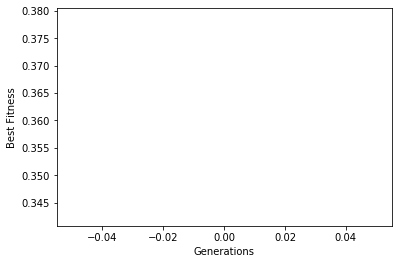

5000/5000 - 0s - loss: 1.7828 - accuracy: 0.3840
5000/5000 - 1s - loss: 0.8847 - accuracy: 0.7188


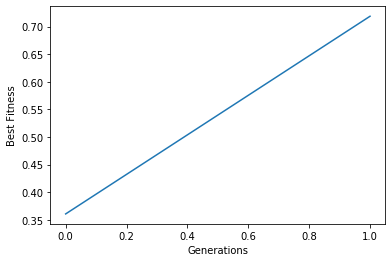

5000/5000 - 0s - loss: 0.4466 - accuracy: 0.8994
5000/5000 - 1s - loss: 0.5571 - accuracy: 0.8520


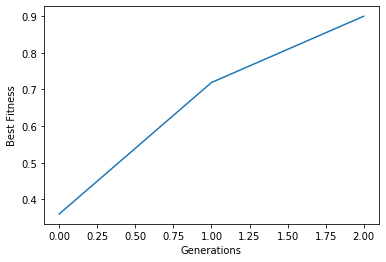

5000/5000 - 1s - loss: 2.0536 - accuracy: 0.3046
5000/5000 - 1s - loss: 1.4812 - accuracy: 0.4838


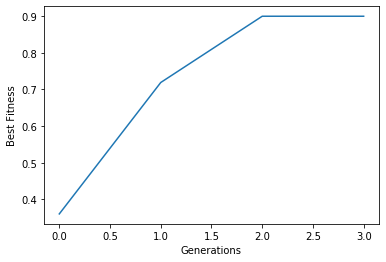

5000/5000 - 0s - loss: 1.0848 - accuracy: 0.6238
5000/5000 - 0s - loss: 0.8446 - accuracy: 0.7336


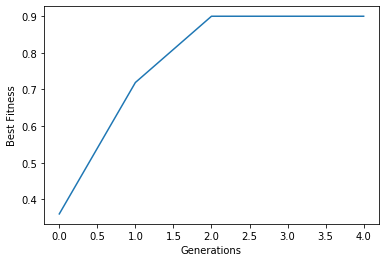

5000/5000 - 0s - loss: 0.3311 - accuracy: 0.9312
5000/5000 - 0s - loss: 0.4546 - accuracy: 0.8892


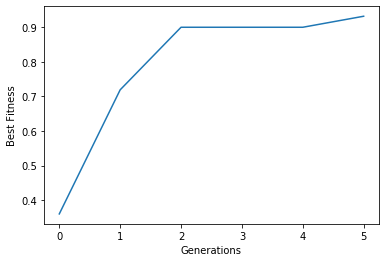

5000/5000 - 1s - loss: 1.0435 - accuracy: 0.6690
5000/5000 - 0s - loss: 0.6115 - accuracy: 0.8226


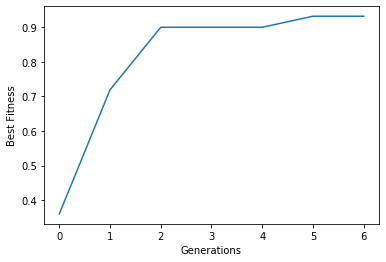

5000/5000 - 0s - loss: 0.9910 - accuracy: 0.6748
5000/5000 - 0s - loss: 1.0791 - accuracy: 0.6466


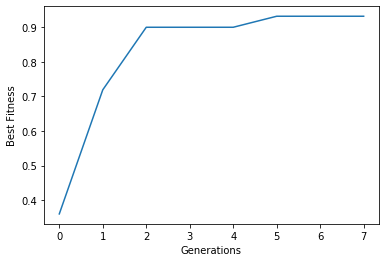

5000/5000 - 0s - loss: 1.1273 - accuracy: 0.6270
5000/5000 - 1s - loss: 0.8668 - accuracy: 0.7226


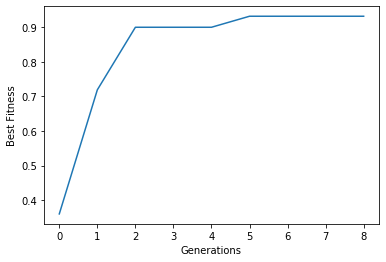

5000/5000 - 0s - loss: 0.9822 - accuracy: 0.6772
5000/5000 - 1s - loss: 0.8717 - accuracy: 0.7096


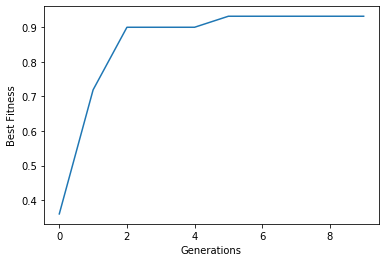

5000/5000 - 0s - loss: 0.9956 - accuracy: 0.6836
5000/5000 - 1s - loss: 0.8895 - accuracy: 0.7178


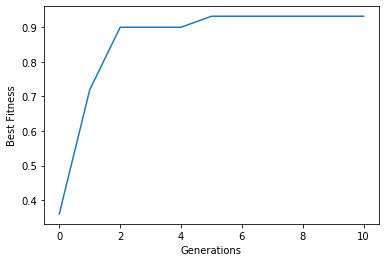

5000/5000 - 0s - loss: 1.3753 - accuracy: 0.5252
5000/5000 - 0s - loss: 0.9568 - accuracy: 0.6886


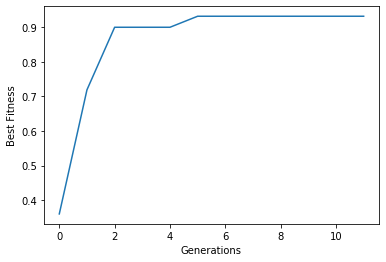

5000/5000 - 0s - loss: 1.1119 - accuracy: 0.6372
5000/5000 - 0s - loss: 0.4221 - accuracy: 0.9062


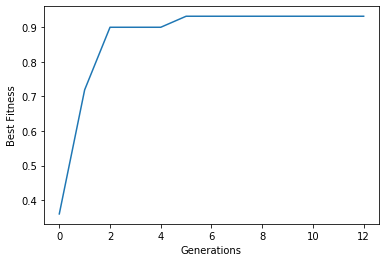

5000/5000 - 1s - loss: 0.8152 - accuracy: 0.7340
5000/5000 - 1s - loss: 1.0969 - accuracy: 0.6292


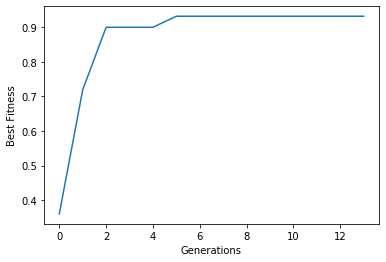

5000/5000 - 0s - loss: 0.5919 - accuracy: 0.8378
5000/5000 - 0s - loss: 0.2527 - accuracy: 0.9494


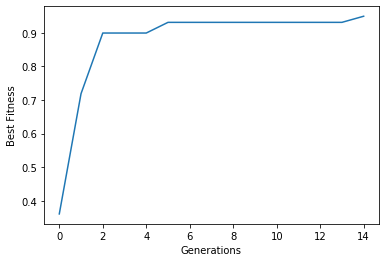

5000/5000 - 0s - loss: 0.6051 - accuracy: 0.8104
5000/5000 - 0s - loss: 0.5666 - accuracy: 0.8430


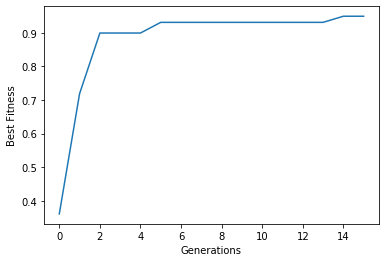

5000/5000 - 0s - loss: 1.3075 - accuracy: 0.5338
5000/5000 - 1s - loss: 0.7681 - accuracy: 0.7786


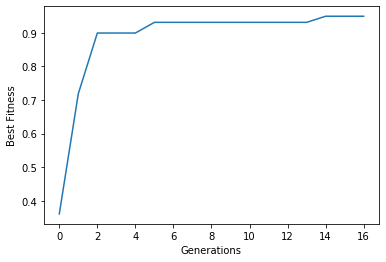

5000/5000 - 0s - loss: 0.7845 - accuracy: 0.7354
5000/5000 - 0s - loss: 1.0501 - accuracy: 0.6482


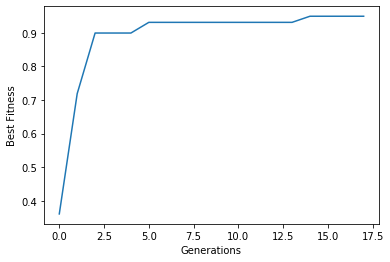

5000/5000 - 0s - loss: 0.9383 - accuracy: 0.6992
5000/5000 - 0s - loss: 0.7558 - accuracy: 0.7498


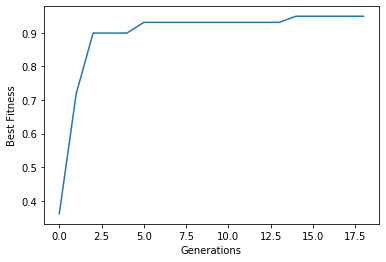

5000/5000 - 0s - loss: 0.9464 - accuracy: 0.7012
5000/5000 - 0s - loss: 1.0164 - accuracy: 0.6748


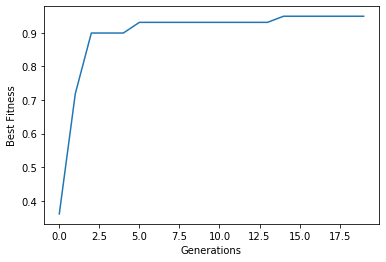

5000/5000 - 0s - loss: 1.1964 - accuracy: 0.6012
5000/5000 - 0s - loss: 1.6881 - accuracy: 0.4286


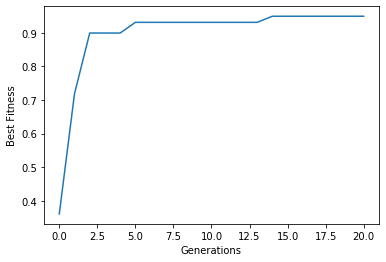

5000/5000 - 0s - loss: 1.3729 - accuracy: 0.5170
5000/5000 - 0s - loss: 0.5177 - accuracy: 0.8644


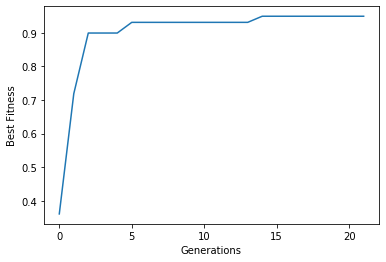

5000/5000 - 0s - loss: 0.2693 - accuracy: 0.9480
5000/5000 - 0s - loss: 0.3285 - accuracy: 0.9350


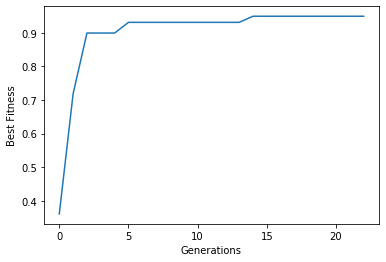

5000/5000 - 0s - loss: 2.3909 - accuracy: 0.2190
5000/5000 - 1s - loss: 1.8328 - accuracy: 0.3576


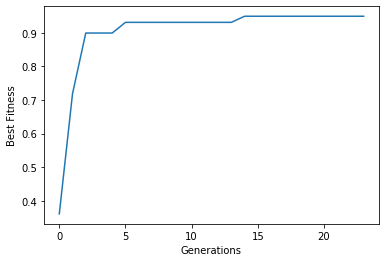

5000/5000 - 0s - loss: 0.3273 - accuracy: 0.9340
5000/5000 - 0s - loss: 0.3096 - accuracy: 0.9368


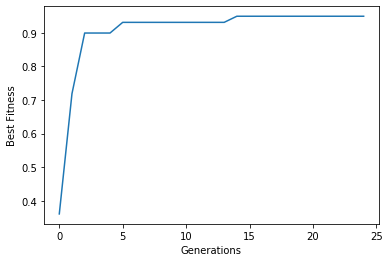

5000/5000 - 0s - loss: 0.3513 - accuracy: 0.9256
5000/5000 - 0s - loss: 0.4331 - accuracy: 0.8962


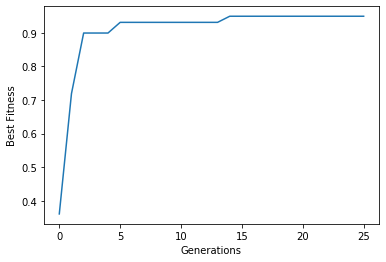

5000/5000 - 0s - loss: 0.5822 - accuracy: 0.8246
5000/5000 - 1s - loss: 0.3116 - accuracy: 0.9292


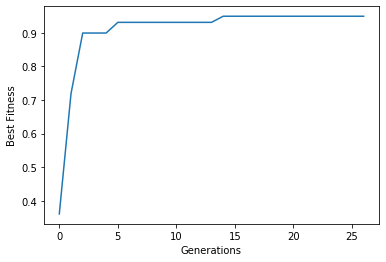

5000/5000 - 1s - loss: 1.1554 - accuracy: 0.5876
5000/5000 - 0s - loss: 0.4197 - accuracy: 0.8960


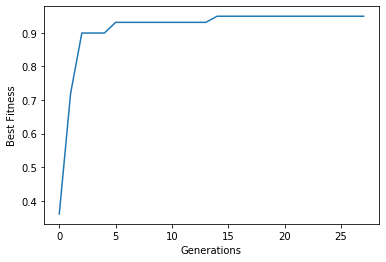

5000/5000 - 0s - loss: 0.6295 - accuracy: 0.8258
5000/5000 - 1s - loss: 1.8259 - accuracy: 0.3594


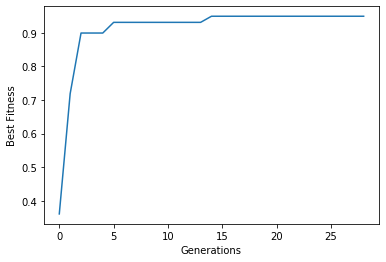

5000/5000 - 0s - loss: 2.4291 - accuracy: 0.2248
5000/5000 - 0s - loss: 0.2782 - accuracy: 0.9458


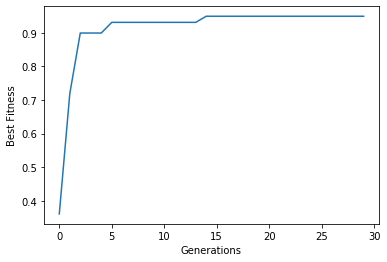

5000/5000 - 0s - loss: 1.2315 - accuracy: 0.5808
5000/5000 - 0s - loss: 1.4955 - accuracy: 0.4686


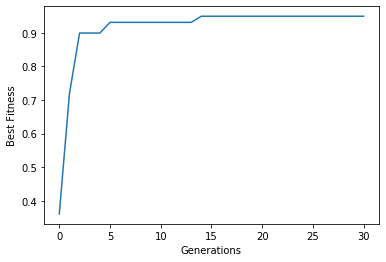

5000/5000 - 0s - loss: 1.0998 - accuracy: 0.6196
5000/5000 - 1s - loss: 0.7114 - accuracy: 0.7638


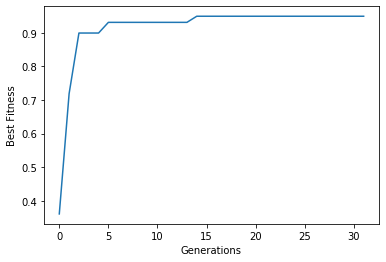

5000/5000 - 0s - loss: 0.3231 - accuracy: 0.9372
5000/5000 - 0s - loss: 0.3336 - accuracy: 0.9280


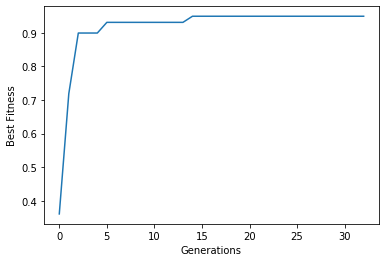

5000/5000 - 0s - loss: 0.7856 - accuracy: 0.7464
5000/5000 - 0s - loss: 0.3703 - accuracy: 0.9256


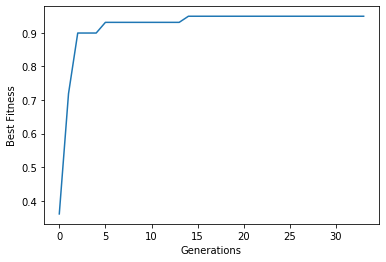

5000/5000 - 0s - loss: 0.3188 - accuracy: 0.9330
5000/5000 - 0s - loss: 0.3087 - accuracy: 0.9404


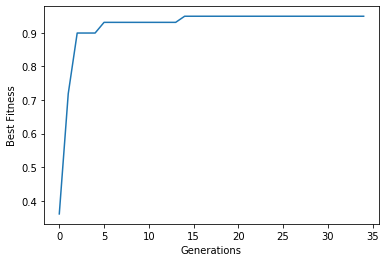

5000/5000 - 1s - loss: 0.9618 - accuracy: 0.6698
5000/5000 - 1s - loss: 0.7412 - accuracy: 0.7722


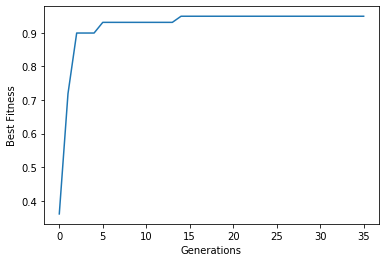

5000/5000 - 0s - loss: 0.7865 - accuracy: 0.7388
5000/5000 - 0s - loss: 1.3001 - accuracy: 0.5370


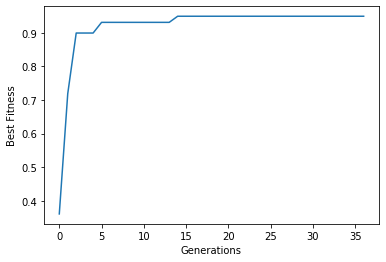

5000/5000 - 0s - loss: 0.2989 - accuracy: 0.9408
5000/5000 - 0s - loss: 0.6013 - accuracy: 0.8168


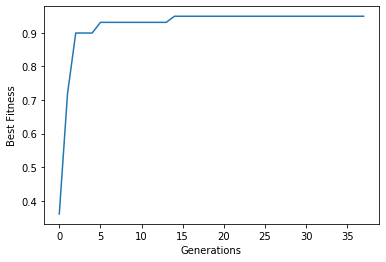

5000/5000 - 1s - loss: 1.3174 - accuracy: 0.5392
5000/5000 - 0s - loss: 1.9141 - accuracy: 0.3206


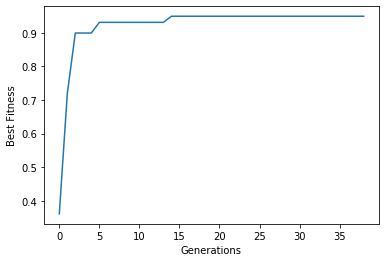

5000/5000 - 0s - loss: 0.9573 - accuracy: 0.7488
5000/5000 - 0s - loss: 2.2967 - accuracy: 0.1970


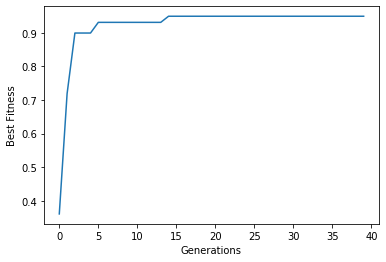

5000/5000 - 0s - loss: 1.4159 - accuracy: 0.5226
5000/5000 - 0s - loss: 1.0868 - accuracy: 0.6486


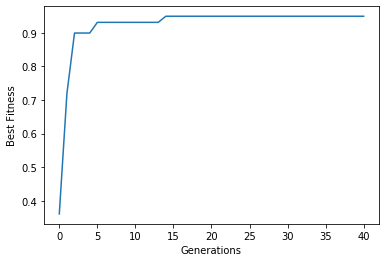

5000/5000 - 0s - loss: 0.4281 - accuracy: 0.8968
5000/5000 - 0s - loss: 0.3833 - accuracy: 0.9154


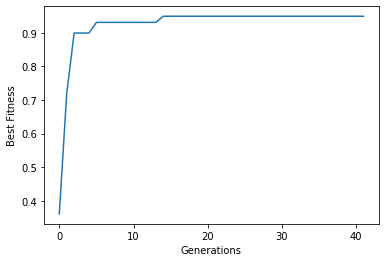

5000/5000 - 0s - loss: 0.3683 - accuracy: 0.9236
5000/5000 - 0s - loss: 0.7169 - accuracy: 0.7680


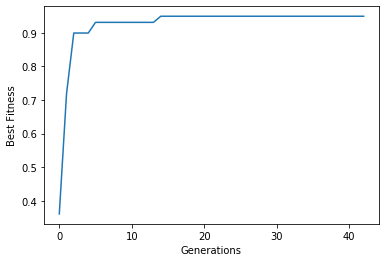

5000/5000 - 0s - loss: 1.4872 - accuracy: 0.4780
5000/5000 - 1s - loss: 0.6574 - accuracy: 0.8048


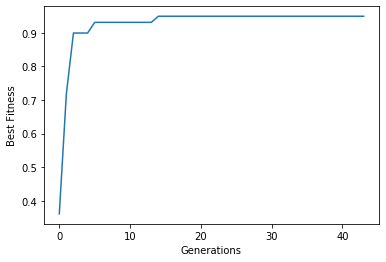

5000/5000 - 0s - loss: 0.3799 - accuracy: 0.9104
5000/5000 - 0s - loss: 1.3911 - accuracy: 0.5272


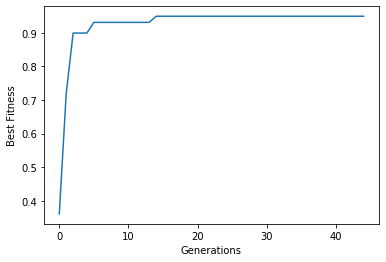

5000/5000 - 0s - loss: 2.0376 - accuracy: 0.2476
5000/5000 - 0s - loss: 0.2593 - accuracy: 0.9496


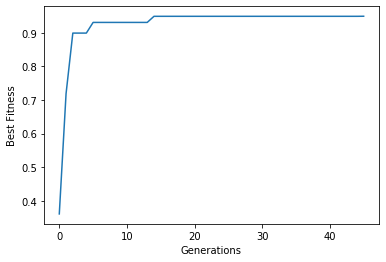

5000/5000 - 0s - loss: 2.1094 - accuracy: 0.2316
5000/5000 - 0s - loss: 1.9191 - accuracy: 0.3190


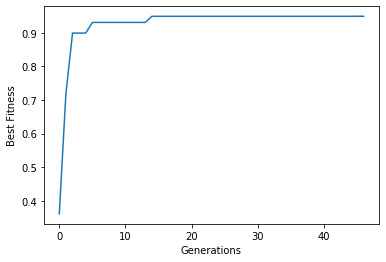

5000/5000 - 1s - loss: 0.8587 - accuracy: 0.7122
5000/5000 - 0s - loss: 0.4667 - accuracy: 0.8788


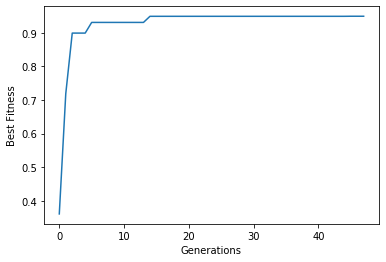

5000/5000 - 0s - loss: 0.3304 - accuracy: 0.9286
5000/5000 - 0s - loss: 0.3632 - accuracy: 0.9274


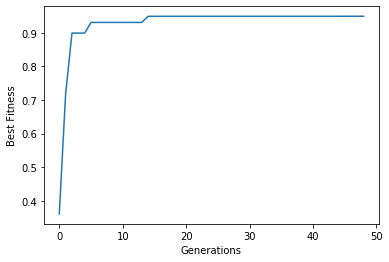

5000/5000 - 0s - loss: 0.3690 - accuracy: 0.9154
5000/5000 - 0s - loss: 0.2517 - accuracy: 0.9500


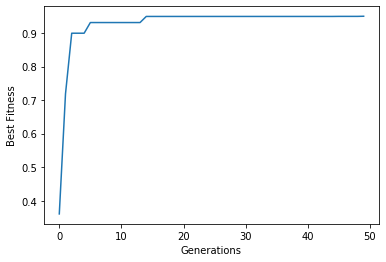

--- 1157.415075302124 seconds ---


In [12]:
best_gene, best_is_active, fitnesses = evolution(gene, is_active, 50, 0.05)

### Show and save optimization phase plot

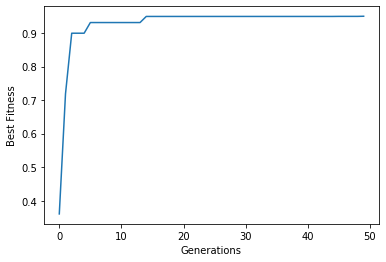

In [13]:
plt.plot(fitnesses)
plt.xlabel('Generations')
plt.ylabel('Best Fitness')
plt.savefig('30cols_10levelsback_05mutationrate_RUN1.png')
plt.show()

## Evaluation

### Test performance of best network on test set
The amount of epochs for training on the full CIFAR-10 dataset can be specified here, as well as the batch size.

In [14]:
# train best network and test
best_network = genotype_to_cnn(best_gene, best_is_active)
print(best_network.summary())
best_network.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
hist = best_network.fit(x_train_full,
                        to_categorical(np.asarray(y_train_full.flatten())), 
                        batch_size=128, 
                        epochs=100)
best_network.evaluate(x_test, y_test)

Model: "sequential_185"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
average_pooling2d_237 (Avera (None, 16, 16, 3)         0         
_________________________________________________________________
conv2d_848 (Conv2D)          (None, 16, 16, 128)       3584      
_________________________________________________________________
conv2d_849 (Conv2D)          (None, 16, 16, 128)       409728    
_________________________________________________________________
max_pooling2d_409 (MaxPoolin (None, 8, 8, 128)         0         
_________________________________________________________________
max_pooling2d_410 (MaxPoolin (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_850 (Conv2D)          (None, 4, 4, 64)          73792     
_________________________________________________________________
conv2d_851 (Conv2D)          (None, 4, 4, 128)      

50000/50000 [==============================] - 5s 99us/sample - loss: 1.1662 - accuracy: 0.6401
Epoch 59/100
50000/50000 [==============================] - 5s 101us/sample - loss: 1.1016 - accuracy: 0.6509
Epoch 60/100
50000/50000 [==============================] - 5s 101us/sample - loss: 1.0478 - accuracy: 0.6611
Epoch 61/100
50000/50000 [==============================] - 5s 100us/sample - loss: 1.0462 - accuracy: 0.6649
Epoch 62/100
50000/50000 [==============================] - 5s 101us/sample - loss: 0.9617 - accuracy: 0.6828
Epoch 63/100
50000/50000 [==============================] - 5s 100us/sample - loss: 0.9323 - accuracy: 0.6922
Epoch 64/100
50000/50000 [==============================] - 5s 100us/sample - loss: 0.8445 - accuracy: 0.7161
Epoch 65/100
50000/50000 [==============================] - 5s 100us/sample - loss: 0.8116 - accuracy: 0.7253
Epoch 66/100
50000/50000 [==============================] - 5s 100us/sample - loss: 0.7713 - accuracy: 0.7376
Epoch 67/100
50000/50000

[1.4724757845878602, 0.6225]

### Show architecture of best gene

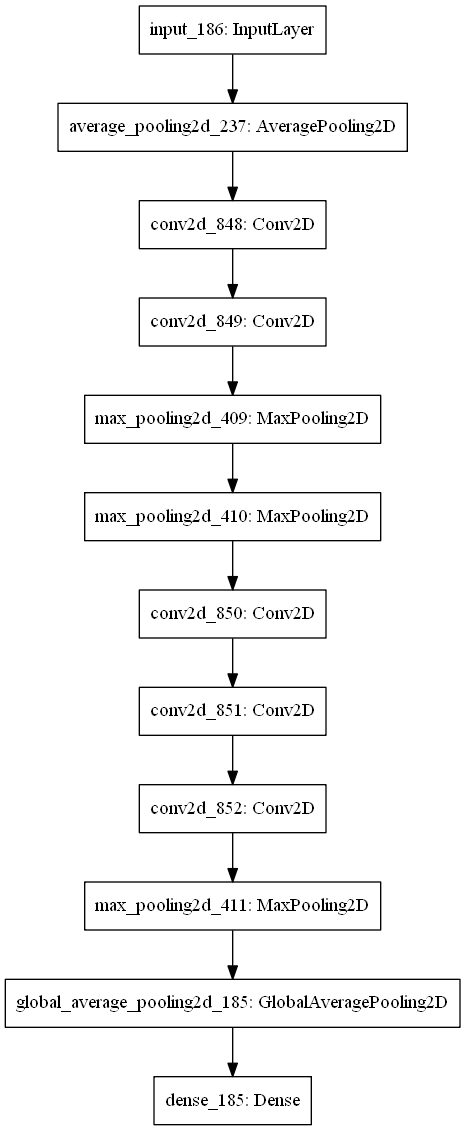

In [15]:
tf.keras.utils.plot_model(best_network, to_file='modelplot-30cols_10levelsback_05mutationrate_RUN1.png', show_shapes=False)